In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),'..','..','..'))
from ursse.hydra_harp_file_reader import HydraHarpFile
from ursse.LED_tests.data_analyzis import calc_Fano, get_time_window_hist, calc_Fano_from_counts_per_time_window
import numpy as np
import pandas as pd
import seaborn as sns
from ursse.data_processing import \
    get_event_delays, plot_arrival_time_hist, get_events_array, get_fanos, \
    plot_fanos_hist, process_file, read_event_delays, save_event_delays
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [15, 3.75]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import ursse.path_assistant as pa
shift = pa.PathAssistant('shift_02_28_2020')

In [2]:
df, n_revolutions = read_event_delays(shift.get_time_stamp_file_path('1el_002.ptu'))
t_delays = df.delay

In [3]:
gate = (61000, 66000)
dt=0.005 # sec

In [4]:
n = 500
i = 200

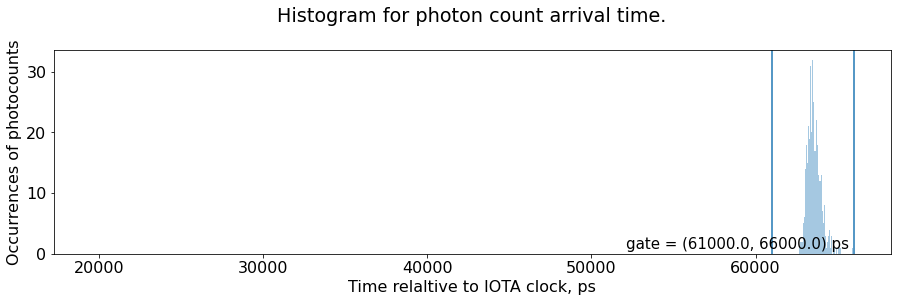

In [5]:
plot_arrival_time_hist(t_delays[i*n:(i+1)*n], gate=gate, bins=1000, yscale='linear')

In [6]:
n_revolutions*133e-9

59.866547461

In [7]:
t_delays_in_gate = t_delays[t_delays.between(gate[0],gate[1])]

In [8]:
len(t_delays_in_gate)/n_revolutions/133e-9

24722.22071874391

In [9]:
from config_ursse import get_from_config
iota_period_sec = get_from_config("IOTA_revolution_period")
dt_sec = get_from_config("dt")
iota_period_au = iota_period_sec/dt_sec

In [10]:
from ursse.time_structure import get_bucket_gates, get_rate_in_gate_Hz

In [11]:
four_gates = get_bucket_gates(gate)
four_gates

[(61000.0, 66000.0),
 (94250.0, 99250.0),
 (127500.00000000001, 132500.0),
 (27750.0, 32750.0)]

In [12]:
get_rate_in_gate_Hz(df, n_revolutions, gate)

24722.22071874391

In [13]:
bucket_dfs = [df[(df.delay > gate[0]) & (df.delay < gate[1])] for gate in four_gates]

In [14]:
df0 = bucket_dfs[0]

In [15]:
revolutions_per_dt = dt/iota_period_sec
revolutions_per_dt

37593.984962406015

In [16]:
df0['index_of_dt_bin'] = (df0.revolution/revolutions_per_dt).astype(int)
df0['time_sec'] = df0['index_of_dt_bin']*dt

<ipython-input-16-27c4b84eb6f7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['index_of_dt_bin'] = (df0.revolution/revolutions_per_dt).astype(int)
<ipython-input-16-27c4b84eb6f7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['time_sec'] = df0['index_of_dt_bin']*dt


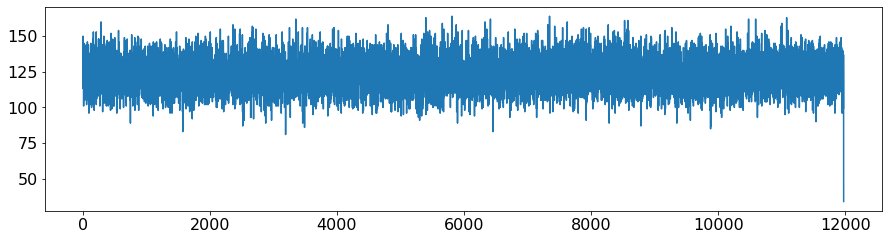

In [17]:
plt.plot(df0.groupby('index_of_dt_bin').delay.count())

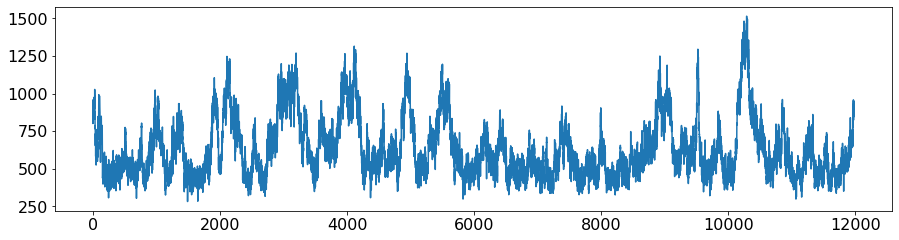

In [18]:
plt.plot(df0.groupby('index_of_dt_bin').delay.std())

In [19]:
df0

,revolution,delay,index_of_dt_bin,time_sec
51,51,62977.0,0,0.000
172,171,64337.0,0,0.000
241,239,62389.0,0,0.000
601,598,63454.0,0,0.000
1004,999,64303.0,0,0.000
...,...,...,...,...
452639788,450123392,63592.0,11973,59.865
452640074,450123677,62846.0,11973,59.865
452640278,450123880,62373.0,11973,59.865
452640330,450123931,62842.0,11973,59.865


In [20]:
xs = df0.groupby('index_of_dt_bin').revolution.apply(np.asarray)
ys = df0.groupby('index_of_dt_bin').delay.apply(np.asarray)

In [21]:
t0=2372

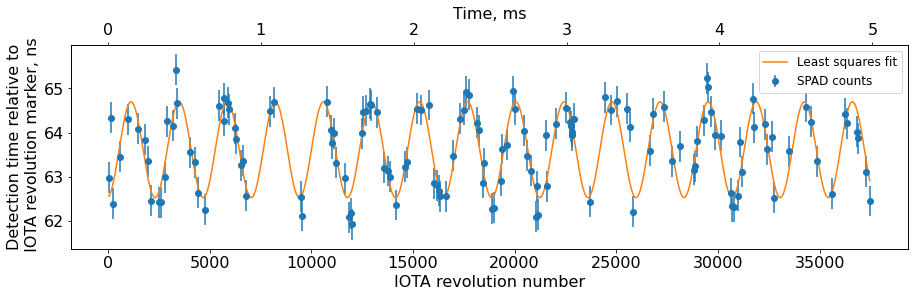

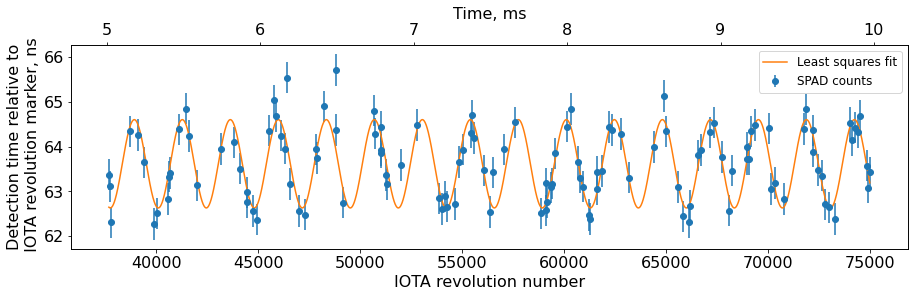

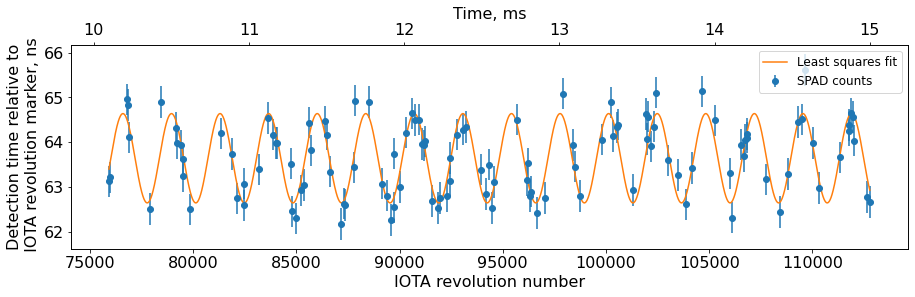

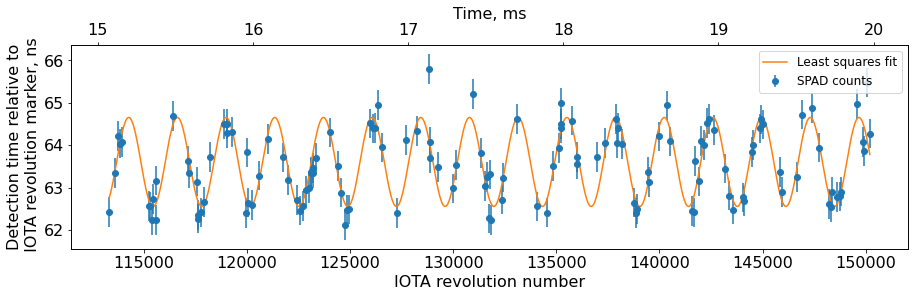

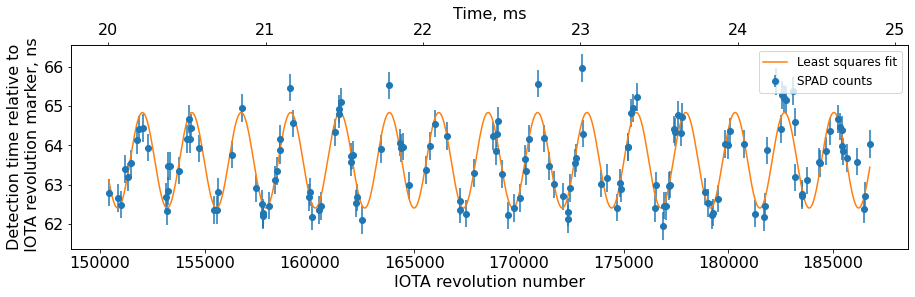

In [31]:
ts = []
for i in range(5):
    x = xs[i]
    x_sec = x*iota_period_sec
    y = ys[i]/1000
    fig, ax = plt.subplots()
    ax.errorbar(x, y, label='SPAD counts', yerr=0.35, marker='o', linestyle='None')
    from scipy.optimize import curve_fit
    def f(t, a0, A, B, T):
        return a0+A*np.cos(2*np.pi/T*t)+B*np.sin(2*np.pi/T*t)
    p0 = (np.mean(y), np.std(y), np.std(y), t0)
    popt, pcov = curve_fit(f, x, y, p0=p0)
    a0, a, b, t = popt
    perr = np.sqrt(np.diag(pcov))
    x_fit = np.linspace(x[0],x[-1],10000)
    x_fit_sec = x_fit*iota_period_sec
    scale = 1.0
    y_fit = f(x_fit, a0, scale*a, scale*b, t)
    ax.plot(x_fit, y_fit, label='Least squares fit')
    ax.set_ylabel('Detection time relative to\n IOTA revolution marker, ns', fontsize=16)
    ax.set_xlabel('IOTA revolution number')
    ax1 = ax.twiny()
    ax1.set_xlim(1000*iota_period_sec*np.asarray(ax.get_xlim()))
    ax1.set_xlabel('Time, ms')
    #ax.set_xlim(0,0.0025)
    ax.legend(loc=1, fontsize=12)
    ts.append(t)
    plt.show()
    np.sqrt(a**2+b**2), t, perr[3]

In [34]:
np.std(ts)

4.359164687782953

In [35]:
np.mean(ts)

2357.7442942008006

In [23]:
from config_ursse import save_to_config

In [24]:
Qs = 1/t0
save_to_config("Qs", Qs)
Qs

0.00042158516020236085

In [25]:
alpha = 0.07086 #0.07679
gamma = get_from_config("gamma")
me = get_from_config("me_MeV")
E = me*gamma*1e6
eta_s = alpha-1/gamma**2
beta = np.sqrt(1-1/gamma**2)
f0 = 1/get_from_config("IOTA_revolution_period")
h = 4
V=383  # V

In [26]:
Qs**2*2*np.pi*beta**2*E/h/V/eta_s

1.0290567207358017

In [27]:
1/200**2

2.5e-05

In [28]:
h*V*alpha/2/np.pi/Qs**2/1e6

97.20965780044003

In [29]:
alpha

0.07086

In [30]:
alpha-1/gamma**2

0.0708338879